# Using beamforming to localize oscillatory power modulations

The aim of this section is to localize the modulations of oscillatory power. This will be done using the Dynamical Imaging of Coherent Sources (DICS) approach (*Gross et al, 2001*). This is a beamforming methodology based on spatial filtering operating in the frequency domain. For each grid point in the brain, a spatial filter is derived based on the forward model and the cross-spectral density (CSD) matrix. A multitaper approach is applied for the spectral estimates. The approach allows for estimating the power modulations at each grid points which then is mapped onto the indiviual structural MRIs. Prewhitening of the data allows for combining the information from the gradiometers and the magnetomers.

## Preparation

Import the relevant Python modules:

In [1]:
import os
import os.path as op
import numpy as np

import mne
from mne_bids import BIDSPath
from mne.cov import compute_covariance
from mne.beamformer import make_dics, apply_dics_csd
from mne.time_frequency import csd_multitaper


File overview

The chapter relies on the input file (embedded in the BIDS structure):

    <BIDS_ROOT>/derivatives/Analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_epo.fif

    <BIDS_ROOT>/derivatives/Analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_src.fif
    <BIDS_ROOT>/derivatives/FreeSurfer
    <BIDS_ROOT>/derivatives/Analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_fwd.fif

Set the paths and name for the data. Note that these will depend on your local setup.


In [2]:
subject = '01'
session = '01'
task = 'SpAtt'  # name of the task
run = '01'  
meg_suffix = 'meg'
epo_suffix = 'epo'
mri_suffix = 'T1w'
bem_suffix = 'bem-sol'
src_suffix = 'src'
fwd_suffix = 'fwd'

#data_path='C:/Users/rakshita/Documents/Cerca_raw_files'
data_path = '/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif'


bids_root = op.join(data_path, "Cerca_Spatt_BIDS")
deriv_root = op.join(bids_root, "derivatives/analysis")

bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=epo_suffix, datatype='meg',
            root=deriv_root, extension='.fif', check=False)


fwd_fname = bids_path.basename.replace(epo_suffix, fwd_suffix)
fwd_file = op.join(bids_path.directory, fwd_fname)
src_file = fwd_file.replace(fwd_suffix, src_suffix)
bem_file = fwd_file.replace(fwd_suffix, bem_suffix)


fs_subject = 'T1s'
fs_root = op.join(bids_root, 'derivatives', 'FreeSurfer')

print(bids_path.basename,bids_path.fpath)
print(src_file)
print(fs_root) 
print(fwd_file)

sub-01_ses-01_task-SpAtt_run-01_epo.fif /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_epo.fif
/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_src.fif
/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer
/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_fwd.fif


## The forward model

In this example we will use the forward model calculated in the previous section 'Head model and forward computations'. The forward model is constructed for the 176 OPM sensors with respect to the volumetric forward solution (not the brain surface solution).


In [3]:
fwd = mne.read_forward_solution(fwd_file)

Reading forward solution from /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (12983 sources, 192 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame



## Reading the trials

Now read the epochs for all trial types:


In [4]:
epochs = mne.read_epochs(bids_path.fpath, proj = False)


Reading /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_epo.fif ...
    Read a total of 8 projection items:
        HFC: l=1 m=-1 (1 x 180) active
        HFC: l=1 m=0 (1 x 180) active
        HFC: l=1 m=1 (1 x 180) active
        HFC: l=2 m=-2 (1 x 180) active
        HFC: l=2 m=-1 (1 x 180) active
        HFC: l=2 m=0 (1 x 180) active
        HFC: l=2 m=1 (1 x 180) active
        HFC: l=2 m=2 (1 x 180) active
    Found the data of interest:
        t =    -749.33 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
219 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)



## Source modeling of modulations of alpha band activity
### Calculating the cross-spectral density matrices for the alpha band

The spatial filters in the DICS beamforming approach are calculated using the forward model and the cross-spectral density (CSD) matrices. We here focus on the -0.9 to -0.4 s interval prior to the onset of the gratings and the 0.1 to 0.6 s interval when the gratings are presented. During the presentation interval, the alpha band activity is suppressed (see the section Time-Frequency Representations of Power).

We start by calculating the CSDs for the 8 to 12 Hz alpha band for all conditions and the pre- and post-interval. Since we are using the multitaper approach we are defining the bandwidth to 3 Hz. This results in one taper (as N < 2 ΔF ΔT = 2 0.5).


In [5]:
print('Baseline Interval')
csd_aleft_pre   = csd_multitaper(epochs['cue_Left'],  fmin=8, fmax=12, tmin=-0.7, tmax=-0.2, bandwidth = 3, low_bias = True, verbose = False, n_jobs=-1)
csd_aright_pre  = csd_multitaper(epochs['cue_Right'], fmin=8, fmax=12, tmin=-0.7, tmax=-0.2, bandwidth = 3, low_bias = True,verbose = False, n_jobs=-1)

print('Cue Interval')
csd_aleft_cue =  csd_multitaper(epochs['cue_Left'],  fmin=8, fmax=12, tmin=0.1, tmax=0.6, bandwidth = 3,  low_bias = True, verbose = False, n_jobs=-1)
csd_aright_cue = csd_multitaper(epochs['cue_Right'], fmin=8, fmax=12, tmin=0.1, tmax=0.6, bandwidth = 3,  low_bias = True, verbose = False, n_jobs=-1)

print('Gratings Interval')
csd_aleft_act =   csd_multitaper(epochs['cue_Left'],  fmin=8, fmax=12, tmin= 1.3, tmax= 1.8, bandwidth = 3, low_bias = True, verbose = False, n_jobs=-1)
csd_aright_act =  csd_multitaper(epochs['cue_Right'], fmin=8, fmax=12, tmin= 1.3, tmax= 1.8, bandwidth = 3, low_bias = True, verbose = False, n_jobs=-1)

Baseline Interval
Cue Interval
Gratings Interval


#### The spatial filters must be based on the covariance matrices combined ('common spatial filter'). Therefore the CSDs are averaged:

In [6]:
csd_acommon = csd_aleft_cue
csd_anoise =  csd_aleft_pre
csd_acommon._data = (csd_aleft_cue._data + csd_aright_cue._data + 
                         csd_aleft_pre._data + csd_aright_pre._data)/4

csd_anoise._data = (csd_aleft_pre._data + csd_aright_pre._data)/2

#### For calculating the spatial filters we also need to derive the rank of the CSD. It will be similar to the the rank of the coveriance matrix:

In [7]:
rank = mne.compute_rank(epochs, tol=1e-5, tol_kind='relative', proj = False)
print(rank)

Computing rank from data with rank=None
    Estimated rank (mag): 171
    MAG: rank 171 computed from 180 data channels with 0 projectors
{'mag': 171}


In [8]:
rank = {'mag': 171}

Note that the rank is 167 eventhough there were 176 used in the calculations. The rank deficiency is caused by the HFC and the ICA algorithms and therefore requires a regulatization before inverting in the beamforming calculation.

## Derive the spatial filters for the alpha band

Now calculate the filters using the forward model `fwd` and the combined CSD matrix `csd_common`. The filters are regularized by loading the diagonal of the covariance matrix with 5% of the sensor power. For each source, the orientation is optimized to maximize the output power. The `noise_csd` is used to perform spatial prewhitening of the data (Sekihara et al. 2008, Engemann and Gramfort 2015, Westner et al. 2021). We use data from the pre-stimulus interval for this purpose. Note that while empty-room data could also be used, here we use task-related baseline data.

Since we are using OPM data, which consists only of magnetometers, the issue of scale differences between sensor types does not apply. Depth bias compensation is applied by setting `depth=0`, allowing for direct comparison across conditions or intervals. The relative comparisons mitigate depth bias. The `mean` in `csd_common.mean()` averages the CSDs over the selected frequency range.

Given that the covariance (or CSD) matrices may still be rank-deficient—though minimally in this case—MNE-Python computes a truncated pseudo-inverse using the effective rank. For the data matrix **X** with rank `k`, the truncated pseudo-inverse **X⁺** is computed via singular value decomposition as:

**X = UΣVᵀ**,  
**X⁺ = VₖΣₖ⁻¹Uₖᵀ**,

where the first `k` diagonal values of Σ and the first `k` columns of **U** and **V** are retained. In our dataset, the rank is 167 out of 176 sensors, indicating a near full-rank dataset. Nevertheless, some regularization is still applied due to the small degree of rank deficiency (`reg=0.001`) to ensure numerical stability during inversion.

In [9]:
afilters = make_dics(epochs.info, fwd, csd_acommon.mean() , noise_csd= None, 
                    reg=0.05, pick_ori='max-power', reduce_rank=True, real_filter=True, rank=rank, depth = 1)

Identifying common channels ...
Dropped the following channels:
['BNC 10 Z', 'O2 H3 Y', 'O9 G3 X', 'Trigger 4', 'AFz B4 X', 'BNC 7 Z', 'Trigger 11', 'Trigger 10', 'BNC 11 Z', 'Trigger 3', 'Trigger 5', 'T14 H6 X', 'BNC 12 Z', 'Trigger 1', 'BNC 13 Z', 'Trigger 6', 'BNC 16 Z', 'T11 G7 Y', 'AFz B4 Y', 'BNC 1 Z', 'T14 H6 Z', 'BNC 3 Z', 'T5 C5 Y', 'Trigger 8', 'AFz B4 Z', 'Trigger 2', 'BNC 5 Z', 'BNC 9 Z', 'BNC 8 Z', 'Trigger 7', 'T14 H6 Y', 'BNC 6 Z', 'BNC 2 Z', 'T5 C5 Z', 'BNC 14 Z', 'Trigger 9', 'BNC 4 Z', 'T1 C7 Z', 'BNC 15 Z']
Computing inverse operator with 180 channels.
    180 out of 180 channels remain after picking
Selected 180 channels
Creating the depth weighting matrix...
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 8)
Computing rank from covariance with rank={'mag': 171}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing rank from covariance with rank={'

In [10]:
stc_aleft_cue, freqs = apply_dics_csd(csd_aleft_cue.mean(), afilters)
stc_aright_cue, freqs = apply_dics_csd(csd_aright_cue.mean(), afilters)

stc_aleft_pre, freqs  = apply_dics_csd(csd_aleft_pre.mean(), afilters)
stc_aright_pre, freqs  = apply_dics_csd(csd_aright_pre.mean(), afilters)

stc_aleft_act, freqs  = apply_dics_csd(csd_aleft_pre.mean(), afilters)
stc_aright_act, freqs  = apply_dics_csd(csd_aright_pre.mean(), afilters)

Computing DICS source power...
[done]
Computing DICS source power...
[done]
Computing DICS source power...
[done]
Computing DICS source power...
[done]
Computing DICS source power...
[done]
Computing DICS source power...
[done]


#### Calculate the relative change in power; i.e. the change in alpha power comparing the interval before and after the moving grating onset. Note that we are always comparing intervals or conditions in order to remove the depth bias confound:

In [11]:
stc_arel = ((stc_aleft_cue + stc_aright_cue) - (stc_aleft_pre + stc_aright_pre)) / (stc_aleft_pre + stc_aright_pre)

#### Calculate the change in relative power for comparing the right versus left attention conditions during the moving gratings interval:

In [12]:
stc_aRvsL = (stc_aright_cue -stc_aleft_cue) / (stc_aright_cue + stc_aleft_cue)
stc_aRvsL_g = (stc_aright_act - stc_aleft_act) / (stc_aright_act + stc_aleft_act)

## Plotting the alpha band modulation

Now plot the source results:

<SourceSpaces: [<volume, shape=(31, 38, 33), n_used=12983>] head coords, subject 'T1s', ~74.5 MiB>
Showing: t = 0.000 s, (23.7, -65.5, 36.3) mm, [20, 4, 19] vox, 22526 vertex
Using control points [0.19031401 0.20510385 0.25636159]


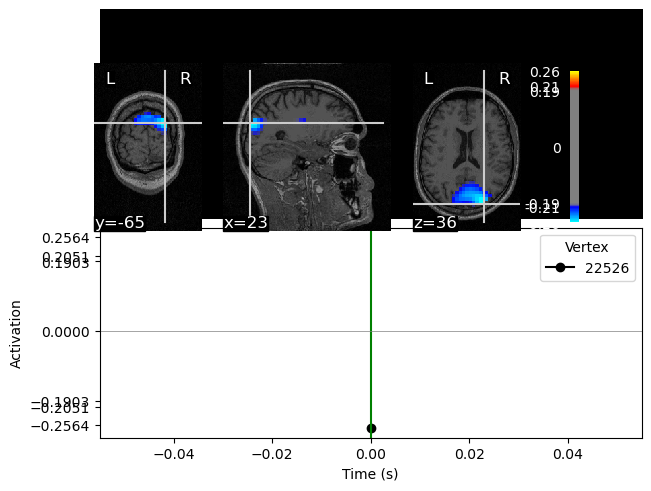

In [13]:
src = fwd['src']
print(src)

%matplotlib inline
stc_arel.plot(src=src, subject=fs_subject, subjects_dir=fs_root, mode='stat_map', verbose = True);

#### The above plot show the relative depression in the alpha following the onset of moving gratings. The blue island reflects the occipital depression in alpha power.


Showing: t = 0.000 s, (-51.3, -40.5, -13.7) mm, [5, 9, 9] vox, 10886 vertex
Using control points [0.08674002 0.09292936 0.12553045]


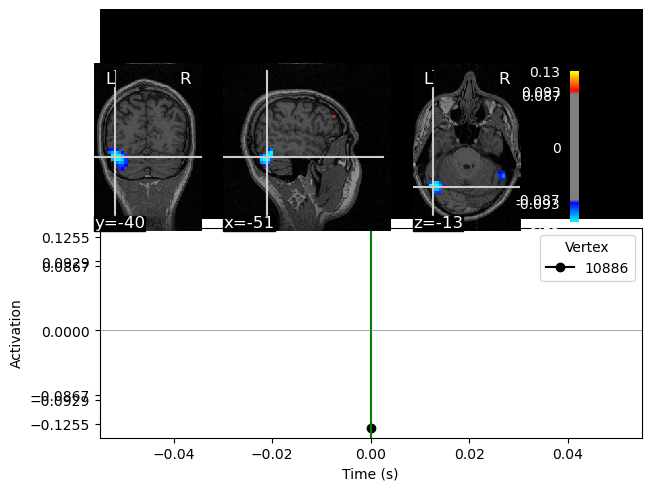

In [14]:
%matplotlib inline
stc_aRvsL.plot(src=src, subject=fs_subject, subjects_dir=fs_root, mode='stat_map');



The sources in the posterior areas reflect the modulation of the alpha band activity when the partipant is attending to the right versus left moving gratings. 

- **Question 1 :** Plot the DISC output (of e.g. stc_aright_act) on the MRI prior to doing a comparision. Interpret the outcome.

- **Question 2 :** Change the rank of the data when calculating the filter to 176: rank={'meg':176}. How does it affect the outcome?



## Source modeling of modulations of gamma band activity

We will next localize the sources associated with the modulation in the 60 - 90 Hz gamma band. For this, we will apply the multitaper approach to ensure suffient spectral smoothing.

As a first step, calculate the CSD for the pre- and post-interval as well as all conditions. The bandwidth here is 2ΔF = 8 Hz and the time window ΔT = 0.475 s. This results in 3 tapers (as N < 2ΔF ΔT).


In [15]:
print('Pre')
csd_gleft_pre   = csd_multitaper(epochs['cue_Left'],  fmin=70, fmax=80, tmin=-0.7, tmax=-0.2, bandwidth = 8, adaptive=True, low_bias = True,verbose = False, n_jobs=4)
csd_gright_pre  = csd_multitaper(epochs['cue_Right'], fmin=70, fmax=80, tmin=-0.7, tmax=-0.2, bandwidth = 8, adaptive=True, low_bias = True,verbose = False, n_jobs=4)

print('Cue')
csd_gleft_cue =  csd_multitaper(epochs['cue_Left'],  fmin=70, fmax=80, tmin=0.6, tmax=1.1, bandwidth = 8, adaptive=True, low_bias = True, verbose = False, n_jobs=4)
csd_gright_cue = csd_multitaper(epochs['cue_Right'], fmin=70, fmax=80, tmin=0.6, tmax=1.1, bandwidth = 8, adaptive=True, low_bias = True, verbose = False, n_jobs=4)

print('Stim')
csd_gleft_act =  csd_multitaper(epochs['cue_Left'],  fmin=70, fmax=80, tmin= 1.2, tmax= 1.7, bandwidth = 8, adaptive=True, low_bias = True, verbose = False, n_jobs=4)
csd_gright_act = csd_multitaper(epochs['cue_Right'], fmin=70, fmax=80, tmin= 1.2, tmax= 1.7, bandwidth = 8, adaptive=True, low_bias = True, verbose = False, n_jobs=4)

Pre
Cue
Stim


In [16]:
csd_gcommon = csd_gleft_cue
csd_gnoise =  csd_aleft_pre

csd_gcommon._data = (csd_gleft_cue._data + csd_gright_cue._data + csd_gleft_act._data + csd_gright_act._data)/4
csd_gnoise._data = (csd_gleft_pre._data + csd_gright_pre._data)/2


## Derive the spatial filters for the gamma band

The filters will be calculated on the basis of the common CSD. The rank estimate based on the covariance matrix will be used. The deduced rank is due to the HFC as well as the ICA.


In [17]:
gfilters = make_dics(epochs.info, fwd, csd_gcommon.mean() , noise_csd=None, reg=0.05, pick_ori='max-power',
                        reduce_rank=True, real_filter=True, rank=rank, depth = 1)

Identifying common channels ...
Dropped the following channels:
['BNC 10 Z', 'O2 H3 Y', 'O9 G3 X', 'Trigger 4', 'AFz B4 X', 'BNC 7 Z', 'Trigger 11', 'Trigger 10', 'BNC 11 Z', 'Trigger 3', 'Trigger 5', 'T14 H6 X', 'BNC 12 Z', 'Trigger 1', 'BNC 13 Z', 'Trigger 6', 'BNC 16 Z', 'T11 G7 Y', 'AFz B4 Y', 'BNC 1 Z', 'T14 H6 Z', 'BNC 3 Z', 'T5 C5 Y', 'Trigger 8', 'AFz B4 Z', 'Trigger 2', 'BNC 5 Z', 'BNC 9 Z', 'BNC 8 Z', 'Trigger 7', 'T14 H6 Y', 'BNC 6 Z', 'BNC 2 Z', 'T5 C5 Z', 'BNC 14 Z', 'Trigger 9', 'BNC 4 Z', 'T1 C7 Z', 'BNC 15 Z']
Computing inverse operator with 180 channels.
    180 out of 180 channels remain after picking
Selected 180 channels
Creating the depth weighting matrix...
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 8)
Computing rank from covariance with rank={'mag': 171}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing rank from covariance with rank={'

## Apply the filters and plot the gamma modulation

The filters are then applied:


In [18]:
stc_gleft_cue, freqs = apply_dics_csd(csd_gleft_cue.mean(), gfilters)
stc_gleft_act, freqs  = apply_dics_csd(csd_gleft_act.mean(), gfilters)
stc_gright_cue, freqs = apply_dics_csd(csd_gright_cue.mean(), gfilters)
stc_gright_act, freqs  = apply_dics_csd(csd_gright_act.mean(), gfilters)

Computing DICS source power...
[done]
Computing DICS source power...
[done]
Computing DICS source power...
[done]
Computing DICS source power...
[done]


#### Now calculate the relative modulation in gamma power with respect to the baseline:

In [19]:
stc_grel = ((stc_gleft_act + stc_gright_act) - (stc_gleft_cue + stc_gright_cue)) / (stc_gleft_cue + stc_gright_cue)

#### and subsequently the hemispheric lateralization with respect to attention:

In [20]:
stc_gRvsL = (stc_gright_act - stc_gleft_act) / (stc_gright_act + stc_gleft_act)

#### and plot the relative modulation in the interactive plot. Click on the visual cortex and note the increase in gamma power.

Fixing initial position: [0.0, -10000.0, 0.0] mm
Showing: t = 0.000 s, (-1.3, -75.5, 1.3) mm, [15, 2, 12] vox, 14213 vertex


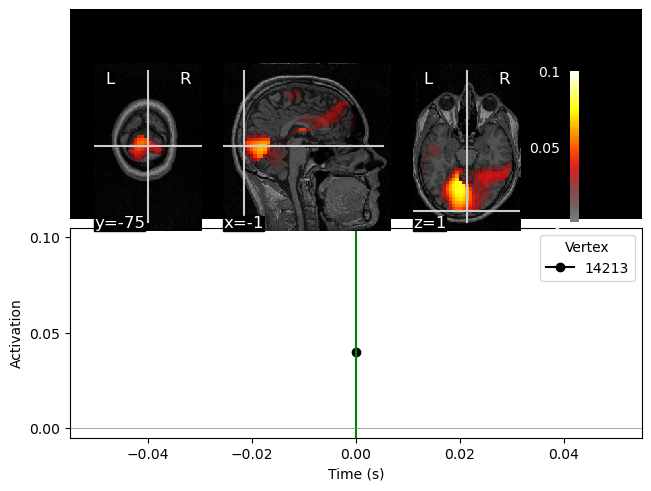

In [55]:
src = fwd['src'] 
%matplotlib inline

brain = stc_grel.plot(src=src,subject=fs_subject, subjects_dir=fs_root, mode='stat_map',initial_pos = [0,-10,0],clim=dict(kind='value', lims=[0,0.05,0.1]));

#### Use the navigation to move to visual cortex. The increase of the gamma activity is correclty localized in early visual cortex along the calcarine sulcus.

To illustrate the modulation in gamma band activity with attention write:


Showing: t = 0.000 s, (53.7, -25.5, 26.3) mm, [26, 12, 17] vox, 20424 vertex


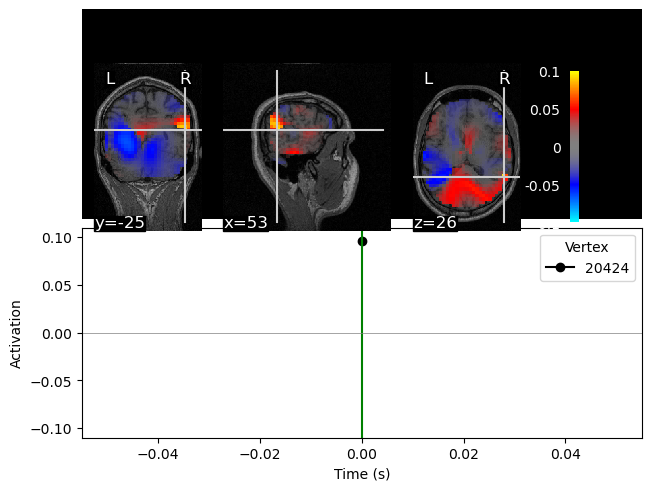

In [28]:
%matplotlib inline
stc_gRvsL.plot(src=src, subject=fs_subject,subjects_dir=fs_root,clim=dict(kind='value', pos_lims=[0.,0.05, 0.1],neg_lims=[0, -0.05, 0.1]));                


## Preregistration and publications

Example for text to be used for publications and preregistration:

"The Dynamics Imaging of Coherent Sources (DICSs) approach (Gross et al., 2001) was applied to localize the modulations of oscillatory brain activity. To localize the modulation in the alpha band, the cross-spectral density (CSD) was calculated for the 8 to 12 Hz band using a multi-taper approach applying 2 Hz spectral smoothing. The CSD matrix was then calculated for the 100 - 600 ms stimulus interval in which the gratings were shown as well as the 300 – 800 ms stimulus interval when the cue was shown (using one DPSS taper). The combined CSD was used with the forward model to create a common spatial filter. This was done by first estimating the rank of the data (being reduced to ~167 due to the HFC and ICA approaches). The data were spatially pre-whitened using the covariance matrix from the baseline interval. The truncated pseudo-inverse was then calculated based on the estimated rank (Jas et al., 2018). For each source, the orientation was optimized to maximize the power of the output. The spatial filter was then applied to the CSDs to calculate the relative change in alpha power. As similar approach was used for the gamma band now considering the 60 - 90 Hz band and 8 Hz spectral smoothing (resulting in 3 DPSS tapers). The pre-stimulus time-interval was -0.6 to -0.1 s and the post-stimulus interval was 0.1s to 0.6 s. The source data were then mapped to the structural MRI. "


## References

- Gross, J., Kujala, J., Hämäläinen, M., Timmermann, L., Schnitzler, A., & Salmelin, R. (2001). Dynamic imaging of coherent sources: Studying neural interactions in the human brain. *Proceedings of the National Academy of Sciences of the United States of America*, **98**(2), 694–699. https://doi.org/10.1073/pnas.98.2.694

- Engemann, D. A., & Gramfort, A. (2015). Automated model selection in covariance estimation and spatial whitening of MEG and EEG signals. *NeuroImage*, **108**, 328–342. https://doi.org/10.1016/j.neuroimage.2014.12.040

- Sekihara, K., Hild, K. E., Dalal, S. S., & Nagarajan, S. S. (2008). Performance of prewhitening beamforming in MEG dual experimental conditions. *IEEE Transactions on Biomedical Engineering*, **55**(3), 1112–1121. https://doi.org/10.1109/TBME.2007.912427

- van Vliet, M., Liljeström, M., Aro, S., Salmelin, R., & Kujala, J. (2018). Analysis of Functional Connectivity and Oscillatory Power Using DICS: From Raw MEG Data to Group-Level Statistics in Python. *Frontiers in Neuroscience*, **12**, 586. https://doi.org/10.3389/fnins.2018.00586

- Westner, B. U., Dalal, S. S., Gramfort, A., Litvak, V., Mosher, J. C., Oostenveld, R., & Schoffelen, J. M. (2021). A unified view on beamformers for M/EEG source reconstruction. *NeuroImage*, **246**, 118789. https://doi.org/10.1016/j.neuroimage.2021.118789
